# Dynamic Factor Model

## Packages and Setting

In [1]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import datetime as dt
from functools import reduce
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
from ExtendedDynamicFactor import ExtendedDynamicFactor, OptimizeExtendedDynamicFactor

%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

## Loading Dataset

In [2]:
def load_gdp(growth=True, quarterly=True, **kwargs):
    gdp = pd.read_csv('data/GDP_2014USD.csv')[['date', 'PH']].rename(columns={'PH': 'GDP'}).dropna()
    gdp['date'] = pd.to_datetime(gdp['date'])
    gdp = gdp.set_index('date')
    if quarterly:
        gdp = gdp.resample('Q').sum()
        gdp = 100 * (gdp / gdp.shift(4) - 1) if growth else gdp
    else:
        gdp = gdp.resample('Y').sum()
        gdp = 100 * (gdp / gdp.shift(1) - 1) if growth else gdp

    return gdp.dropna()

In [3]:
def load_tweets(keywords=['PE'], metrics=['TBweight_cl2rt', 'VADERweight_cl2rt'], **kwargs):
    tweets = pd.read_csv('data/PH_Tweets.csv')
    tweets['date'] = pd.to_datetime(tweets['date'])
    tweets = tweets.set_index('date')
    keywords = keywords if len(keywords) > 0 else list(tweets['keyword'].unique())
    metrics = metrics if len(metrics) > 0 else list(tweets.columns.drop(['keyword']))
    tweets = tweets[metrics + ['keyword']]
    tweets_keyword = [tweets[tweets['keyword'] == keyword].drop(columns=['keyword']).add_suffix(f'_{keyword}') for keyword in keywords]
    tweets = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer', sort=True), tweets_keyword)

    return tweets

In [4]:
def load_data(vintage, window=0, **kwargs):
    # READ GDP DATA
    lag = 41
    gdp = load_gdp(**kwargs)
    gdp = gdp.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage) - relativedelta(days=lag), :]
    gdp_scaler = StandardScaler().fit(gdp[['GDP']])
    gdp['GDP'] = gdp_scaler.transform(gdp[['GDP']])
    gdp.index = pd.PeriodIndex(gdp.index, freq='M')

    # READ TWEET DATA
    tweets = load_tweets(**kwargs)
    tweets = tweets.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage), :]
    tweets.index = pd.PeriodIndex(tweets.index, freq='M')
    
    # MERGE DATA
    while tweets.index[-1].month % 3 != 0:
        tweets.loc[tweets.index[-1] + pd.offsets.MonthEnd(1), :] = np.nan
    tweets = pd.concat([tweets.shift(l).add_suffix(f'.L{l}') for l in range(3)], axis=1)
    tweets = tweets.loc[tweets.index.month % 3 == 0, :]
    df = pd.merge(tweets, gdp, how='outer', on='date', sort=True)
    df.index = pd.PeriodIndex(df.index, freq='Q')
    df = df.tail(math.ceil(window / 3)) if window > 0 else df

    return df, gdp_scaler

## Quarter to Annual GDP Growth Conversion

In [5]:
def quarter_to_annual(vintage, nowcasts):
    # LOAD GDP DATA
    lag = 41
    quarter_gdp = load_gdp(False, True)
    quarter_gdp = quarter_gdp.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage) - relativedelta(days=lag), :]
    quarter_gdp.index = pd.PeriodIndex(quarter_gdp.index, 'Q')
    annual_gdp = load_gdp(False, False)
    annual_gdp = annual_gdp.loc[dt.datetime(2010,1,1) : pd.to_datetime(vintage) - relativedelta(days=lag), :]
    annual_gdp.index = pd.PeriodIndex(annual_gdp.index, 'Y')

    # GET QUARTERLY GDP
    for m in range(4):
        quarter = 3 * (m + 1)
        prev_quarter = vintage - relativedelta(years=1) + relativedelta(month=quarter)
        nowcasts[m] = quarter_gdp.loc[prev_quarter, 'GDP'] * (1 + nowcasts[m] / 100)
        # PAD OBSERVED
        curr_quarter = vintage + relativedelta(month=quarter)
        nowcasts[m] = quarter_gdp.loc[curr_quarter, 'GDP'] if curr_quarter in quarter_gdp.index else nowcasts[m]
    
    # GET ANNUAL GDP GROWTH
    prev_year = vintage - relativedelta(years=1)
    return 100 * (np.sum(nowcasts) / annual_gdp.loc[prev_year, 'GDP'] - 1)

## Model Fitting & Nowcasting

In [6]:
def load_DFMmodel(vintage_now, factor_order, error_order, k_factors, factor_lag, window, optimize_order, **kwargs):
    # LOAD DATA
    df, gdp_scaler = load_data(vintage_now, window, **kwargs)
    
    # FIT MODEL
    if optimize_order:
        model = OptimizeExtendedDynamicFactor(
            endog=df, k_factors_max=k_factors, factor_lag_max=factor_lag, factor_order_max=factor_order, 
            error_order=error_order, **kwargs
        ).optimize(**kwargs)
    else:
        model = ExtendedDynamicFactor(
            endog=df, k_factors=k_factors, factor_lag=factor_lag, factor_order=factor_order, 
            error_order=error_order, **kwargs
        )
    results = model.fit(disp=False, maxiter=1000, method='powell', ftol=1e-5, **kwargs)
    
    return results, (model.factor_order, model.error_order, model.k_factors, model.factor_lag), gdp_scaler

In [7]:
def runDFM(factor_order, error_order, k_factors, factor_lag, window=0, optimize_order=False, **kwargs):
    # PRINT SPECIFICATIONS
    print(f'DFM Order: ({factor_order}, {error_order}, {k_factors}, {factor_lag})')
    if optimize_order:
        print('[WARNING] Input orders are used as upper limits with optimize_order')
    print(f'Window: {window}')

    # LOAD ACTUAL GDP
    actual_gdp = load_gdp(True, False)
    actual_gdp.index = pd.PeriodIndex(actual_gdp.index, 'Y')

    # SAVED RESULTS
    results = []
    if not os.path.exists(f'Results'):
        os.makedirs(f'Results')

    # FORECAST DATES   
    vintage_now = dt.datetime(2017, 1, 1)
    vintage_end = dt.datetime(2022, 12, 1)
    delta = relativedelta(months=1)

    while vintage_now <= vintage_end:
        # GET ACTUAL GDP
        actual = actual_gdp.loc[vintage_now, 'GDP']
        
        try:
            # FIT MODEL
            model, (factor_order, error_order, k_factors, factor_lag), gdp_scaler = load_DFMmodel(vintage_now, factor_order, error_order, k_factors, factor_lag, window, optimize_order, **kwargs)
            
            # CURRENT VINTAGE
            print(f'Vintage: {vintage_now.date()} \t {(factor_order, error_order, k_factors, factor_lag)}')
                
            # GET FORECASTS
            nowcasts = model.predict(start=f'{vintage_now.year}Q1', end=f'{vintage_now.year}Q4')[['GDP']]
            nowcasts = list(gdp_scaler.inverse_transform(nowcasts[['GDP']]).squeeze())
            nowcast = quarter_to_annual(vintage_now, nowcasts)
            
            # APPEND RESULTS
            results.append([vintage_now, vintage_now.year, (factor_order, error_order, k_factors, factor_lag), nowcast, actual])
        
        except Exception as ex:
            with open(f'Results/{str(vintage_now.date())}_W{window}_error.txt', 'w') as f:
                f.write(str(ex))
            
            results.append([vintage_now, vintage_now.year, (factor_order, error_order, k_factors, factor_lag), np.nan, actual])

        vintage_now += delta

    # SUMMARIZE RESULTS
    results = pd.DataFrame(results, columns=['date', 'Target', 'Order', 'Nowcast', 'Actual'])
    results['date'] = pd.to_datetime(results['date'])
    results['Period'] = np.where(results['Target'] < 2020, 1, 0)
    results['Year'] = results['Target']
    results['Month'] = results['date'].dt.month % 12

    # RMSE CALCULATIONS
    results['Difference'] = results['Nowcast'] - results['Actual']
    results['Overall RMSE'] = np.sqrt(np.power(results['Difference'].dropna(), 2).mean())
    for period in ['Month', 'Year', 'Period']:
        results = results.set_index(period)
        results[f'{period} RMSE'] = results.groupby(period).apply(lambda dff: np.sqrt(np.power(dff['Difference'].dropna(), 2).mean()))
        results = results.reset_index()
    results = results.drop(columns=['Period', 'Year', 'Month'])

    # SAVE AGGREGATED RESULTS
    if kwargs.get('save_aggregate', True):
        header = 'OPT' if optimize_order else f'({factor_order},{error_order},{k_factors},{factor_lag})'
        results.to_csv(f'Results/{header}_W{window}_summary.csv', index=False)
    
    return results

DFM Order: (1, 1, 1, 0)
Window: 0
Vintage: 2017-01-01 	 (1, 1, 1, 0)
Vintage: 2017-02-01 	 (1, 1, 1, 0)
Vintage: 2017-03-01 	 (1, 1, 1, 0)
Vintage: 2017-04-01 	 (1, 1, 1, 0)
Vintage: 2017-05-01 	 (1, 1, 1, 0)
Vintage: 2017-06-01 	 (1, 1, 1, 0)
Vintage: 2017-07-01 	 (1, 1, 1, 0)
Vintage: 2017-08-01 	 (1, 1, 1, 0)
Vintage: 2017-09-01 	 (1, 1, 1, 0)
Vintage: 2017-10-01 	 (1, 1, 1, 0)
Vintage: 2017-11-01 	 (1, 1, 1, 0)
Vintage: 2017-12-01 	 (1, 1, 1, 0)
Vintage: 2018-01-01 	 (1, 1, 1, 0)
Vintage: 2018-02-01 	 (1, 1, 1, 0)
Vintage: 2018-03-01 	 (1, 1, 1, 0)
Vintage: 2018-04-01 	 (1, 1, 1, 0)
Vintage: 2018-05-01 	 (1, 1, 1, 0)
Vintage: 2018-06-01 	 (1, 1, 1, 0)
Vintage: 2018-07-01 	 (1, 1, 1, 0)
Vintage: 2018-08-01 	 (1, 1, 1, 0)
Vintage: 2018-09-01 	 (1, 1, 1, 0)
Vintage: 2018-10-01 	 (1, 1, 1, 0)
Vintage: 2018-11-01 	 (1, 1, 1, 0)
Vintage: 2018-12-01 	 (1, 1, 1, 0)
Vintage: 2019-01-01 	 (1, 1, 1, 0)
Vintage: 2019-02-01 	 (1, 1, 1, 0)
Vintage: 2019-03-01 	 (1, 1, 1, 0)
Vintage: 2019-04-01 	

,date,Target,Order,Nowcast,Actual,Difference,Overall RMSE,Month RMSE,Year RMSE,Period RMSE
0,2017-01-01,2017,"(1, 1, 1, 0)",NaN,6.930988,NaN,5.283497,NaN,0.277701,0.253630
1,2017-02-01,2017,"(1, 1, 1, 0)",NaN,6.930988,NaN,5.283497,NaN,0.277701,0.253630
2,2017-03-01,2017,"(1, 1, 1, 0)",6.770068,6.930988,-0.160921,5.283497,7.582713,0.277701,0.253630
3,2017-04-01,2017,"(1, 1, 1, 0)",6.770168,6.930988,-0.160821,5.283497,7.480777,0.277701,0.253630
4,2017-05-01,2017,"(1, 1, 1, 0)",6.812196,6.930988,-0.118793,5.283497,7.534073,0.277701,0.253630
...,...,...,...,...,...,...,...,...,...,...
67,2022-08-01,2022,"(1, 1, 1, 0)",7.786207,7.599235,0.186971,5.283497,5.602982,0.881130,7.467688
68,2022-09-01,2022,"(1, 1, 1, 0)",7.731489,7.599235,0.132253,5.283497,0.581392,0.881130,7.467688
69,2022-10-01,2022,"(1, 1, 1, 0)",7.602292,7.599235,0.003057,5.283497,1.147096,0.881130,7.467688
70,2022-11-01,2022,"(1, 1, 1, 0)",7.090382,7.599235,-0.508853,5.283497,1.183129,0.881130,7.467688


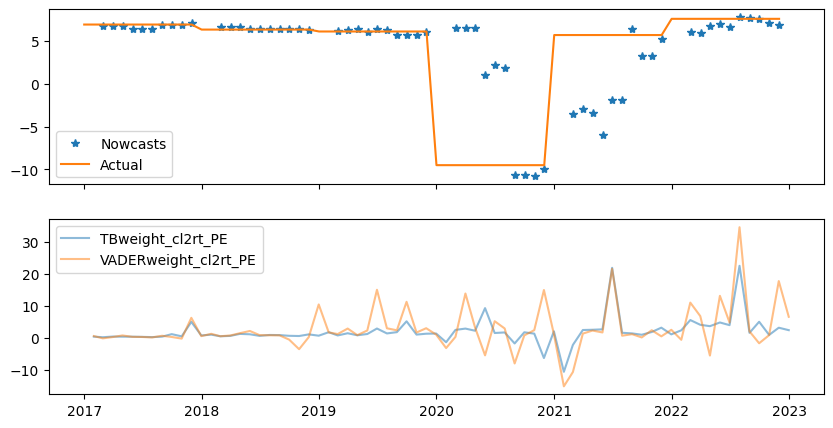

In [8]:
results = runDFM(factor_order=1, error_order=1, k_factors=1, factor_lag=0, window=0, optimize_order=False)
# results = pd.read_csv('Results/(1,1,1,0)_W0_summary.csv', parse_dates=['date'])
tweets = load_tweets().loc[dt.datetime(2017,1,1):,:]
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
axs[0].plot(results['date'], results['Nowcast'], linewidth=0, marker='*', label='Nowcasts')
axs[0].plot(results['date'], results['Actual'], label='Actual')
for metric in tweets.columns:
    axs[1].plot(tweets.index, tweets[metric], label=metric, alpha=0.5)
axs[0].legend()
axs[1].legend()
fig.show()
results